The scripts included in this notebook are prepared for the purpose of reproducing the research results.

Code authored by X. and X.

Source code cloning from GitHub

In [ ]:
! git clone https://github.com/browarsoftware/FrangiNeuron.git

Cloning into 'FrangiNeuron'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 173 (delta 86), reused 164 (delta 85), pack-reused 0
Receiving objects: 100% (173/173), 30.30 MiB | 20.98 MiB/s, done.
Resolving deltas: 100% (86/86), done.


Required additional libraries not installed in Colab

In [ ]:
! pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


Setting the system path to the code sources

In [ ]:
PATH = './FrangiNeuron'

import sys
sys.path.append(PATH + "/sources/")

Defining a model using FrangiLayers blocks

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.models import Sequential, Model
import tensorflow_addons as tfa

from random import randint
from numpy import random

import cv2

# code implementing augmentation
import augmenter
# some utility function
import utils
# implementation of FrangiLayer and auxiliary functions
from frangi_module import FrangiLayer, ScaleLayer, Scaling01

# model definition
inp = Input(shape=(None, None, 1))
abc_list = []

for sigma in [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 5, 6, 7, 8, 9, 10]:
    ml = FrangiLayer(sigma=sigma)(inp)
    ml = ScaleLayer()(ml)
    abc_list.append(ml)

x = keras.layers.Maximum()(abc_list)
x = Scaling01()(x)
model = Model(inp, x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 frangi_layer_19 (FrangiLayer)  (None, None, None,   2           ['input_2[0][0]']                
                                1)                                                                
                                                                                                  
 frangi_layer_20 (FrangiLayer)  (None, None, None,   2           ['input_2[0][0]']                
                                1)                                                          

Settings needed for localization of training and test data

In [ ]:
# chooosing image dedicated to trainng phase
# a single image is sufficient to train the model effectively
img_id = 3

DATA_NAME = 'arteries'
DATA_FOLDER = '/data/' + DATA_NAME + '/images/'
MANUAL_FOLDER = '/data/' + DATA_NAME + '/manual/'
FILE_FILTER = '*.tif'
TRAINING_IMAGES = PATH + DATA_FOLDER + str(img_id) + FILE_FILTER
MANUAL_IMAGES = PATH + MANUAL_FOLDER + str(img_id) + FILE_FILTER

LOC_FOR_WEIGHTS = PATH + '/weights/model_weights.' + DATA_NAME + '.{epoch:03d}.hdf5'
LOC_FOR_MODELS = PATH + "/models/" + "model.best_" + str(img_id) + "." + DATA_NAME + ".h5"


Training the model

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras import losses
from glob import glob

# Callback function
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=LOC_FOR_WEIGHTS)
]

# selecting training data consisted of raw image + reference manual
train_data = list(zip(sorted(glob(TRAINING_IMAGES)), sorted(glob(MANUAL_IMAGES))))
                      
# batch size settings
batch_size = 16
#  model compilation
model.compile(optimizer=Adam(learning_rate=1e-2), loss=losses.binary_crossentropy, metrics=['accuracy'])

history = model.fit(augmenter.gen(train_data, au=True), epochs=50, verbose=True,
                    steps_per_epoch=100 * len(train_data) // batch_size,
                    callbacks=my_callbacks)

# Save model weights
model.save(LOC_FOR_MODELS)

Epoch 1/50
6/6 [==============================] - 18s 220ms/step - loss: 0.5759 - accuracy: 0.9417
Epoch 2/50
6/6 [==============================] - 1s 191ms/step - loss: 0.5688 - accuracy: 0.9435
Epoch 3/50
6/6 [==============================] - 1s 193ms/step - loss: 0.6123 - accuracy: 0.9407
Epoch 4/50
6/6 [==============================] - 1s 195ms/step - loss: 0.6507 - accuracy: 0.9321
Epoch 5/50
6/6 [==============================] - 1s 194ms/step - loss: 0.5093 - accuracy: 0.9517
Epoch 6/50
6/6 [==============================] - 1s 196ms/step - loss: 0.6750 - accuracy: 0.9299
Epoch 7/50
6/6 [==============================] - 1s 194ms/step - loss: 0.9887 - accuracy: 0.8954
Epoch 8/50
6/6 [==============================] - 1s 192ms/step - loss: 0.5655 - accuracy: 0.9380
Epoch 9/50
6/6 [==============================] - 1s 193ms/step - loss: 0.6449 - accuracy: 0.9364
Epoch 10/50
6/6 [==============================] - 1s 196ms/step - loss: 0.6710 - accuracy: 0.9320
Epoch 11/50
6/6 [=

Evaluation of model performance on data not used for learning

In [ ]:
from glob import glob
import os
import cv2

# Path to directory with test data
TEST_IMAGES = PATH + DATA_FOLDER + FILE_FILTER
files = glob(TEST_IMAGES)
a = 0
while a < len(files):
    if files[a].find(str(img_id)) > 0:
        trained_image = files.pop(a)
    else:
        a = a + 1

files.append(trained_image)

model.load_weights(LOC_FOR_MODELS)

trial = utils.trialContextManager()

LOC_FOR_RESULTS = './results/'
LOC_FOR_RESULTS_SUB = 'results_' +str(img_id) + '/'

with trial: os.mkdir(LOC_FOR_RESULTS)
with trial: os.mkdir(LOC_FOR_RESULTS + LOC_FOR_RESULTS_SUB)

raw_images = []
segmented_images = []
segmented_images_inv = []
for num, ff in enumerate(files):
    file_name_write = os.path.basename(ff)
    file_path = LOC_FOR_RESULTS
    file_name_read = ff
    image = utils.load_image(file_name_read)
    image = cv2.resize(image, dsize=(image.shape[1], image.shape[0]))

    raw_images.append(image)

    image = cv2.bitwise_not(image)    # added by marp, invertion

    cc = np.expand_dims(image, axis=2)
    cc = np.expand_dims(cc, axis=0)  # / 255.0
    cc = cc.astype(float)

    tt = model.predict(cc)
    fi = tt[0, :, :, 0]
    max_max = np.nanmax(fi)
    fi *= 255.0 / max_max
    fi = fi.astype(np.uint8)

    segmented_images.append(fi)
    segmented_images_inv.append(cv2.bitwise_not(fi))

    if num < len(files) - 1:
      cv2.imwrite(LOC_FOR_RESULTS+ LOC_FOR_RESULTS_SUB + file_name_write, cv2.bitwise_not(fi))    

Visual presentation of how the model works 

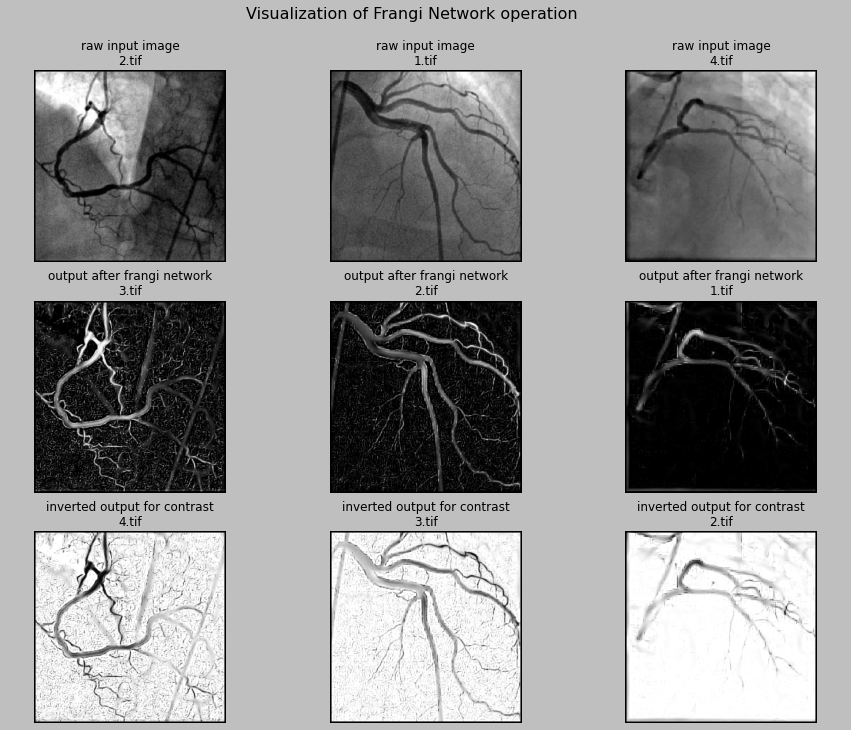

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(15, 12))
plt.suptitle('Visualization of Frangi Network operation', ha='center', va='baseline', size=16, x=.5, y=.94)
plt.axis('off')
fig.patch.set_facecolor('gray')
fig.patch.set_alpha(0.5)

columns = 3
rows = 3
ax = []
n_files = 3
labels = ['raw input image'] * n_files + ['output after frangi network'] * n_files + ['inverted output for contrast'] * n_files

for i, img in enumerate(raw_images[:n_files] + segmented_images[:n_files] + segmented_images_inv[:n_files]):

    border_h = (5, 5)
    border_v = (5, 5)
    img = np.pad(img, (border_v, border_h), constant_values=0)

    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title(labels[i] + "\n" + files[i%(n_files+1)].split('/')[-1])
    ax.axis('off')

    plt.imshow(img, cmap='gray')

plt.show()